# Digital epidemiology
### University of Trento
### AA 2023/2024

Author: Michele Tizzoni

---
## Notebook 1
### Epidemic modeling, deterministic and stochastic models

In [6]:
import networkx as nx
import numpy as np

from operator import itemgetter
from collections import defaultdict

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import seaborn as sns



%matplotlib is a magic function in IPython. I'll quote the relevant documentation here for you to read for convenience:

    IPython has a set of predefined ‘magic functions’ that you can call with a command line style syntax. There are two kinds of magics, line-oriented and cell-oriented. Line magics are prefixed with the % character and work much like OS command-line calls: they get as an argument the rest of the line, where arguments are passed without parentheses or quotes. Lines magics can return results and can be used in the right hand side of an assignment. Cell magics are prefixed with a double %%, and they are functions that get as an argument not only the rest of the line, but also the lines below it in a separate argument.

%matplotlib inline sets the backend of matplotlib to the 'inline' backend:

    With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

When using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code. It may be worth also reading How to make IPython notebook matplotlib plot inline for reference on how to use it in your code.

If you want interactivity as well, you can use the nbagg backend with %matplotlib notebook (in IPython 3.x), as described here.



In [2]:
%matplotlib inline

## The deterministic SIR model

As a first step, we solve the differential equations of an SIR model with the Euler method. 

We set the parameters of the model

There is no way to find an analytical solution, what we can do is integrate by step using a method like Euler's method.

First, we need to define the parameters of the model, so the rates mu, beta and the reproductive number R0

In [3]:
mu = 0.2 #recovery rate

R0 = 3.0 #basic reproductive number

beta1 = R0 * mu #transmissibility

In [4]:
beta1

0.6000000000000001

In [5]:
print("The average infectious period is ", 1.0 / mu, " days")

The average infectious period is  5.0  days


The time step of integration is 1 day.

We fix the population size, the initial number of infected, the initial number of susceptile and the initial number of recovered.

We create also objects (St, It (the pervalence=number of infectious individuals at a given time), Rt) that are lists that we use to store teh variations on teh variables S, I and R.

We also have store the Delta's. deltaSt is the number of new infected in teh time step deltat.

In [6]:
N = 1000000
I = 10
S = N - I
R = 0

St = []
It = []
Rt = []

deltaSt = []
deltaIt = []

St.append(S)
It.append(I)
Rt.append(R)

while I>0.01: # if we put I>0 than the while will never stop because since I is a float number, it will get smaller and smaller but will never get to 0

    # formula obtained from the models -> they are the variations for teh compartments S and R
    deltaSI = beta1 * float(I) * S / N

    deltaIR = mu * I

    # compute the new values of S, I, R
    S = S - deltaSI
    I = I + deltaSI - deltaIR
    R = R + deltaIR

    # add the new values to our list
    deltaSt.append(deltaSI)
    deltaIt.append(deltaIR)
    St.append(S)
    It.append(I)
    Rt.append(R)

In [7]:
print("The final attack rate is ", Rt[-1] / N)

The final attack rate is  0.953213389771602


The final attack rate is the final number of individuals that recovered at the end of the epidemic.
We can see that it is equal to circa 95%.

We plot the time varying curves of S, I and R

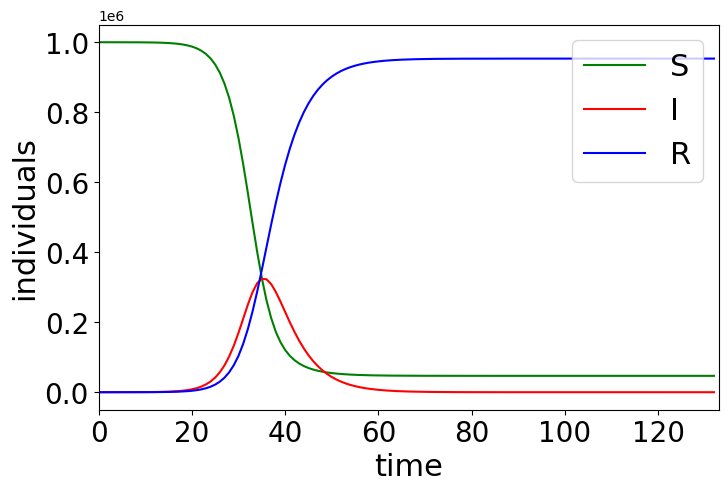

In [9]:
plt.figure(figsize=(8, 5))

plt.plot(range(0, len(St)), np.array(St), label="S", color="g")
plt.plot(range(0, len(It)), np.array(It), label="I", color="r")
plt.plot(range(0, len(Rt)), np.array(Rt), label="R", color="b")

# plt.yscale('log')
# plt.xscale('log')
plt.xlim([0, len(It)])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("time", fontsize=22)
plt.ylabel("individuals", fontsize=22)

plt.legend(loc="upper right", fontsize=22)

We can see that the obtained plot explained the variation of the variables I, S and R over time. We have the same graph that we saw at lectures, it is the typical SIR behaviour.

By chainging R0, we have variations in the value of the final attack rate (as R0 grows, the attack rate grows) and the behaviour of the plot, indeed, the infected have an higher peack and the infection finish earlier than with smaller R0.

We can plot the incidence and the newly recovered

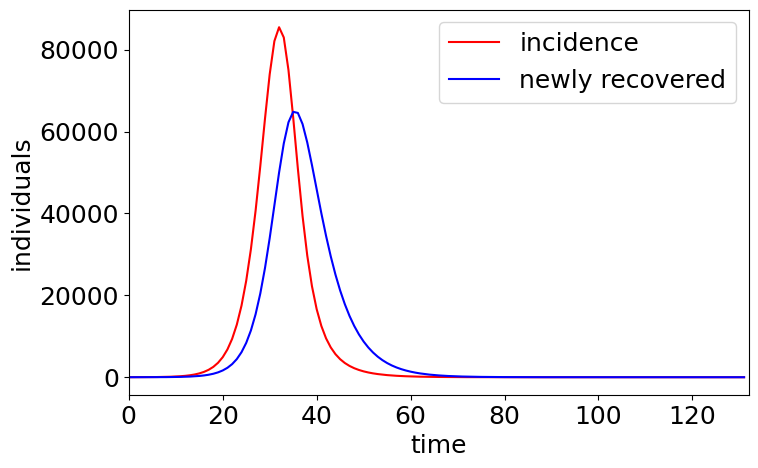

In [8]:
plt.figure(figsize=(8, 5))

plt.plot(range(0, len(deltaSt)), np.array(deltaSt), label="incidence", color="r")
plt.plot(range(0, len(deltaIt)), np.array(deltaIt), label="newly recovered", color="b")
# plt.plot(range(0, len(Rt)),np.array(Rt), label='R', color='b')

# plt.yscale('log')
plt.xlim([0, len(deltaIt)])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("time", fontsize=18)
plt.ylabel("individuals", fontsize=18)

plt.legend(loc="upper right", fontsize=18)

The plot explains the incidence and the newly recovered. We can see that there is a shift in the curve between the new infected and the new recovered, since there is a relapse in the model, first we get infected and only after a certain time we recover.

## The stochastic SIR

We simulate a discrete and stochastic SIR model by randomly extracting the transition elements at each time step.
Since the simulations are stochastic, we need to run several realizations of the model and then extract their statistical averages.

We use the same parameters as in the deterministic case. We just introduce random numbers.

We use the same model's parameters: $R_0=3.0$

In [10]:
mu = 0.2
R0 = 3.0
beta1 = R0 * mu

In [11]:
dict_I = defaultdict(list)  # here we store the number of I at each time step, for each run
# we store this info in a dictionary, we use defaultdict(list) to define a dictionaty in which we use lists as values, each list will contain the values of the infected.
# The keys will be teh time step in which we are.
# We will get someting like: {"0.1":[100, 200, 300], "0.2":[300, 400, 600], ...} 

In [12]:
final_R = [] # to store the attack rates, ergo the number of recovered at the end of the infection

nrun = 1000 # number of time we will run

Irun = [] # empty list that will contain other list -> list of list -> each list will contain the results of a single run


for r in range(0, nrun):

    # for each run r, we set the initial conditions
    N = 1000000
    I = 10
    S = N - I
    R = 0

    # list_i is the list of infected individuals that will end up in Irun
    list_I = []
    list_I.append(I)

    # we start at time 0
    t = 0
    dict_I[t].append(I) # so at time 0 we will have infected equal to I. We can append cause we define the key with t and teh value to teh key t is a list

    while I > 0: # we use I>0 cause we have no longer floats but integers

        p = beta1 * (float(I) / N) # probability of succes for the binamial extraction
        # deltaSI: how many suseptibles become infected?
        deltaSI = np.random.binomial(S, p) # we extract the binomial, we have S trials with probability p. It will be an integer

        # deltaIR: how many infected becomes recover?
        deltaIR = np.random.binomial(I, mu) # we extract, we have I trials with probability mu. It will be an integer

        # compute the new values for S, I and R
        S = S - deltaSI
        I = I + deltaSI - deltaIR
        R = R + deltaIR

        # update the time, increases it of 1
        t += 1
        # append the new infected value to list_I and to the dict
        list_I.append(I)

        dict_I[t].append(I)

    final_R.append(float(R) / N)
    Irun.append(list_I)

print("The average final attack rate is ", np.average(np.array(final_R))) # the final attack rate is teh average of all teh attack rates.

The average final attack rate is  0.953216097


# Distribution of the final size

We plot a histogram of the distribution of the final attack rate

We have a value of the attack rate for each simulation (we did 1000 simulations), we can create an histogram to understand the distribution.

We will see that they are really similar between each other! We get a very nice bell shape, given by teh small fluctuations given by teh fact we are in a stochastic simulation.

Text(0, 0.5, 'runs')

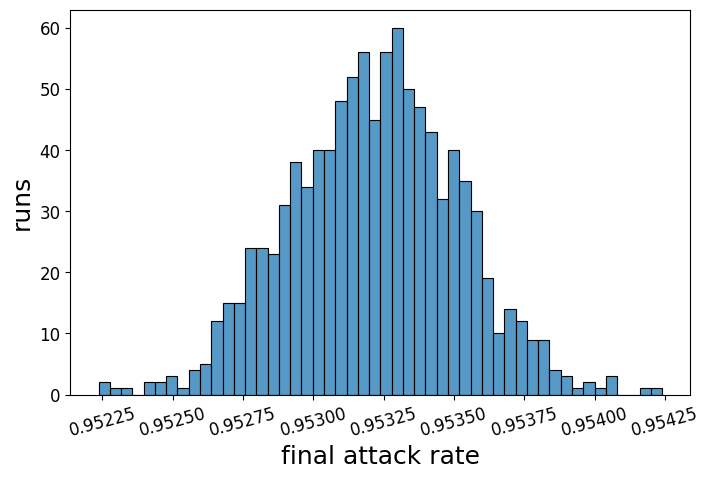

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(final_R, bins=50)

plt.xticks(fontsize=12, rotation=15)
plt.yticks(fontsize=12)

plt.xlabel("final attack rate", fontsize=18)
plt.ylabel("runs", fontsize=18)

We can also plot the prevalence for each run. We have thousand lines, that will get one over the other, tehy have all the same shape, but some outbreak started earlier than other and other finished later than other. This is because we are in a stochastic simulation.

It is really complicated to read this plot, we can use a boxplot instead. 


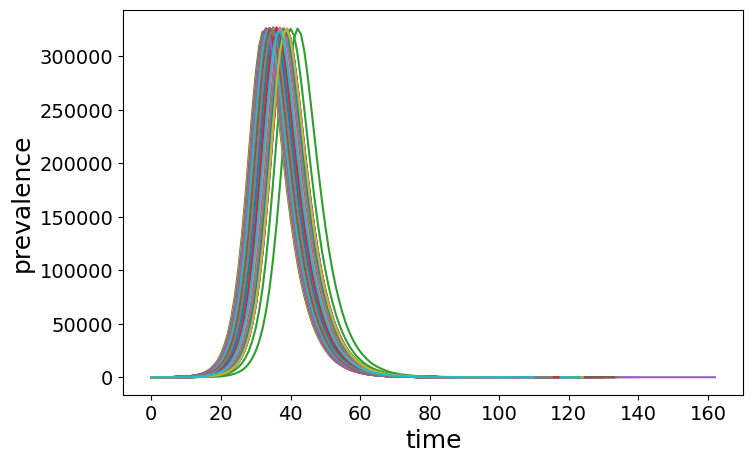

In [14]:
plt.figure(figsize=(8, 5))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("time", fontsize=18)
plt.ylabel("prevalence", fontsize=18)

for r in Irun:

    sns.lineplot(r)

Too many lines are messy... let's draw a boxplot. With boxplot we can represent statistical distribution of the dataset. A boxplot contain teh median, the interquantile range plus wiskers that contains circa 95% of teh data, plus, finally, outliers.

(20.0, 60.0)

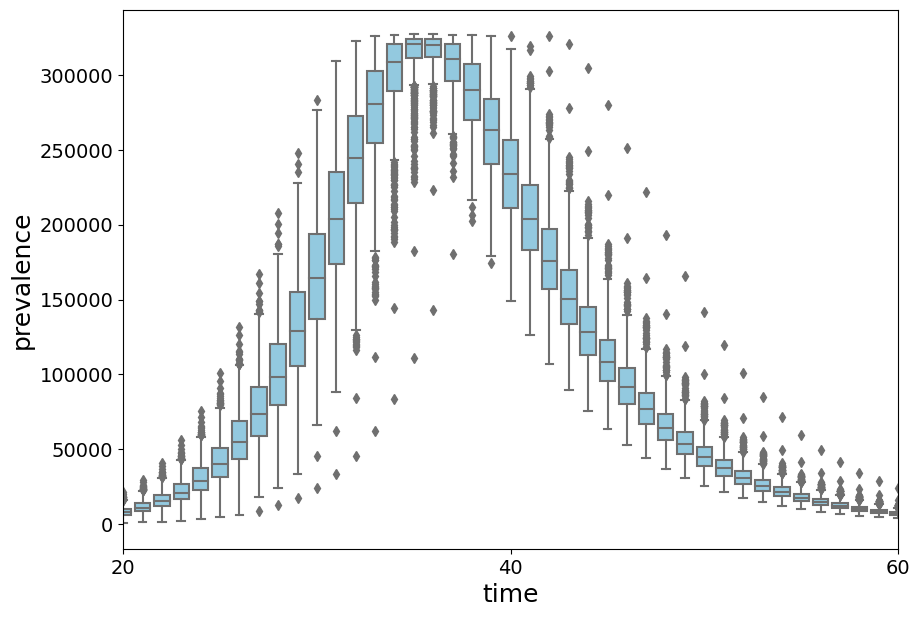

In [15]:
full_array = [np.array(dict_I[t]) for t in dict_I]

plt.figure(figsize=(10, 7))

plt.xlabel("time", fontsize=18)
plt.ylabel("prevalence", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax = sns.boxplot(data=full_array, color="skyblue")

ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.xlim([20, 60])
# plt.show()

At each time step we have the distribution of the infected.

The intresting part is between 20 and 60 so we look only at that time steps.

In a gaussian distribution, teh boxplots are perfectly simmetrical. We can see that for these data we have no simmetrical boxplots, specifically at the peak at time equal to 35.

Let's compare the result with the deterministic simulation by computing the average prevalence of the stochastic version.

We plot the boxplots and the curve obtained from the deterministic simulation.

In [16]:
full_average = [np.average(np.array(dict_I[t])) for t in dict_I]

(20.0, 40.0)

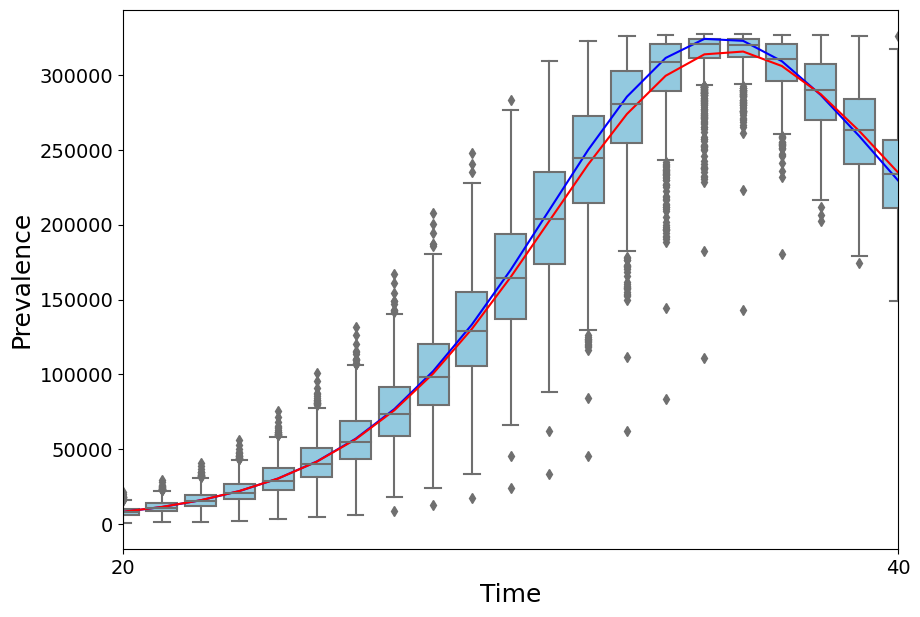

In [17]:
plt.figure(figsize=(10, 7))

plt.xlabel("Time", fontsize=18)
plt.ylabel("Prevalence", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax = sns.boxplot(data=full_array, color="skyblue")

plt.plot(range(0, len(It)), It, color="b")
plt.plot(range(0, len(full_average)), full_average, color="r")

ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.xlim([20,40])


The average does not correspond to the median, we have teh average in red, in blue it is the deterministic simulation.

# Dependence on the initial conditions

The results of the stochastic version of the model depend on the initial conditions. We will see very different behaviours if we look at the stochastic and deterministic behaviour.

Let's change the initial number of infected individuals to 1, keeping the value of $R_0$ constant. The rest of the code is equal to above.

In [18]:
mu = 0.2
R0 = 3.0
beta1 = R0 * mu

In [19]:
dict_I = defaultdict(list)  # here we store the number of I at each time step, for each run

final_R = []

nrun = 1000
Irun = []
for r in range(0, nrun):

    # for each run r, we set the initial conditions
    N = 1000000
    I = 1 # the number of initial infected individuals is 1
    S = N - I
    R = 0

    list_I = []

    t = 0
    dict_I[t].append(I)
    while I > 0:

        p = beta1 * (float(I) / N)
        deltaSI = np.random.binomial(S, p)

        deltaIR = np.random.binomial(I, mu)

        S = S - deltaSI
        I = I + deltaSI - deltaIR
        R = R + deltaIR

        t += 1
        list_I.append(I)

        dict_I[t].append(I)

    final_R.append(float(R) / N)
    Irun.append(list_I)

print("The average final attack rate is ", np.average(np.array(final_R)))

The average final attack rate is  0.7406305829999998


The average attack rate dropped at circa 76%. This is because we have more fluctuations. Indeed, in teh plot under, we have teh curvers more distant to each other, there is a wider range.

**With only 1 infected as a seed, we see more fluctuations, as expected.**

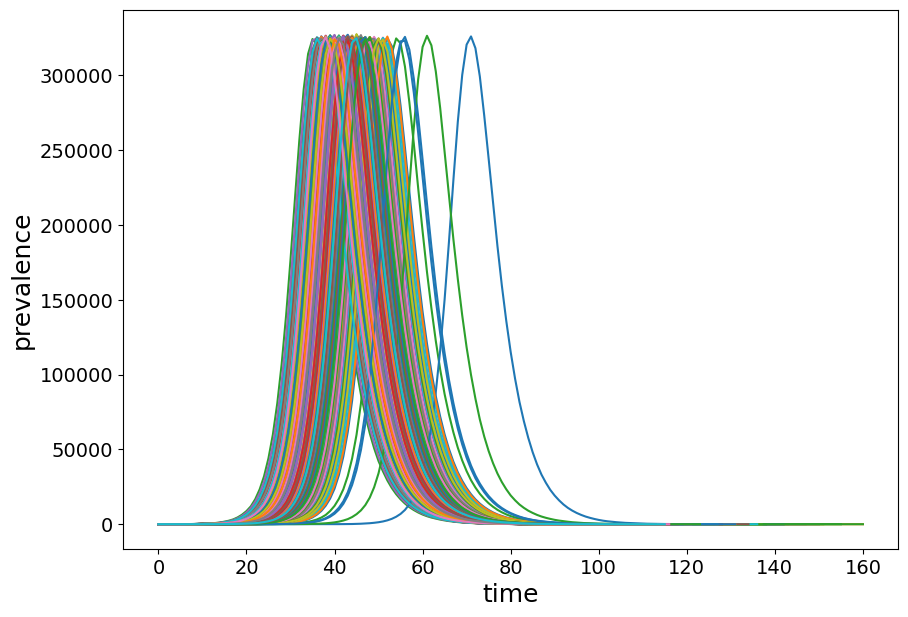

In [21]:
plt.figure(figsize=(10, 7))
plt.xlabel("time", fontsize=18)
plt.ylabel("prevalence", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for r in Irun:

    plt.plot(range(0, len(r)), r)

## We have several runs without outbreak!  

The initial seed individual recovers before infecting someone else.

The chain of transmission breaks down.

We can see that there are a significant amount of simulations in which there was no outbreak because the single individuals was not able to sustain the trasmission. This is something we will never see in the deterministic simulation but this is really close to reality.

In [30]:
no_outbreak = []
for r in final_R:
    if r < 0.8:
        no_outbreak.append(r * 1000000)
print(no_outbreak)

[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 3.0, 1.0, 1.0, 1.0, 8.0, 1.0, 3.0, 2.0, 3.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 6.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 4.0, 1.0, 5.0, 1.0, 1.0, 2.0, 1.0, 1.0, 10.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 7.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 4.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 8.0, 1.0, 4.0, 1.0, 2.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 4.0, 1.0, 3.0

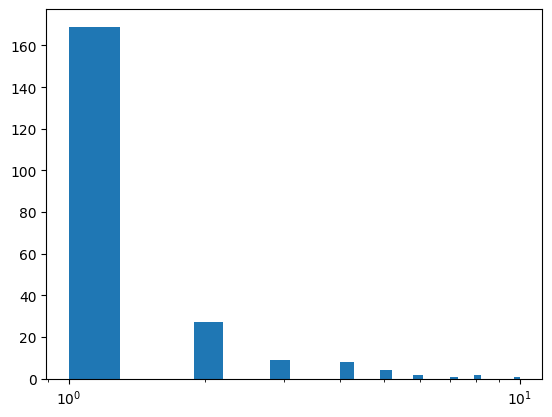

In [27]:
b = plt.hist(no_outbreak, bins=30)
plt.xscale("log")

(array([  0., 100., 200., 300., 400., 500., 600., 700., 800., 900.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600'),
  Text(0, 700.0, '700'),
  Text(0, 800.0, '800'),
  Text(0, 900.0, '900')])

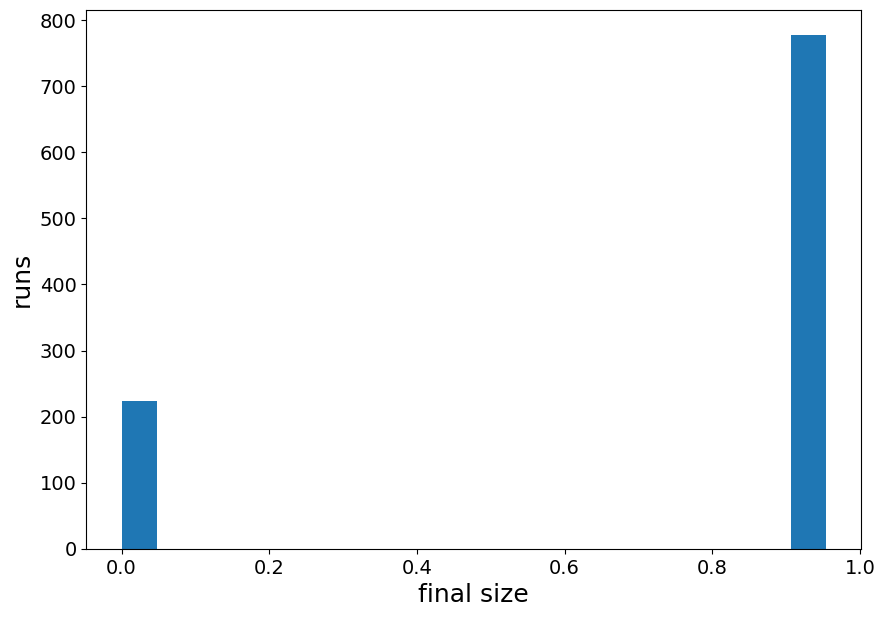

In [28]:
plt.figure(figsize=(10, 7))
plt.hist(final_R, 20)
plt.xlabel("final size", fontsize=18)
plt.ylabel("runs", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

We have a numer of simulation in which there was no outbreak.

In [31]:
len(no_outbreak)

223

---
In a stochastic SIR model, the probability of an outbreak is equal to 
<center>
$p_{outb}=1-(\frac{1}{R_0})^{I_0}$
</center>

---

We can see that if R0 is equal to 3 and I0 equal to 1, we have a probability of outbreak that is circa 2/3. Indeed, in the histogram above, we have rougly 1/3 of the simulations in which there was no outbreak, while circa in 2/3 there was the outbreak.

In [ ]:
p_outbreak = 1 - 1 / R0

In [ ]:
p_outbreak

Of course, such fluctuations do not affect the deterministic model, where the outcome is fixed. 

In [ ]:
N = 10000
I = 1
S = N - I
R = 0


St = []
It = []
Rt = []

St.append(S)
It.append(I)
Rt.append(R)

while I > 0.5:
    deltaSI = beta1 * (float(I) * float(S) / N)
    deltaIR = mu * I

    S = S - deltaSI
    I = I + deltaSI - deltaIR
    R = R + deltaIR

    St.append(S)
    It.append(I)
    Rt.append(R)

In [ ]:
print("The final attack rate is ", Rt[-1] / N)

--- 
# Age-structured SEIR epidemic model

Here, we develop an age-structured epidemic model where the population is divided into age classes. We use a stochastic model in which indivisuals are caractherized by age.

S = susceptible; 

E = exposed; 

I = infected; 

R= recovered.

In [4]:
import pandas as pd

import scipy.linalg as la

# Contact matrix

First, we need to define the contact matrix for the population of interest.
We can use the Polymod contact data that were collected by [Mossong et al. 2008](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.0050074). The contact survey of the cited paper was named Polymod. This paper is really important and the data is acessible without problems.

The data is easily accessible in different formats.
The most convenient way to get a Polymod contact matrix is thorugh the R package [socialmixr](https://cran.r-project.org/web/packages/socialmixr/vignettes/socialmixr.html) developed by [Sebastian Funk](https://www.lshtm.ac.uk/aboutus/people/funk.sebastian) (sometimes R is useful! :) ). This package allows us to build contact matrices starting from contact data like the Polymod data, defining the coutry and the age limits of the groups.

I have used the following R command to generate the contact matrix of Italy, with 9 age brackets

```R
contact_matrix(polymod, countries = "Italy", age.limits = c(0, 10, 20, 30, 40, 50, 60, 70, 80, 90), symmetric = TRUE, per.capita = TRUE)
```

and saved the result into the file ```matrix_Italy.csv```




Text(0, 0.5, 'age class participant')

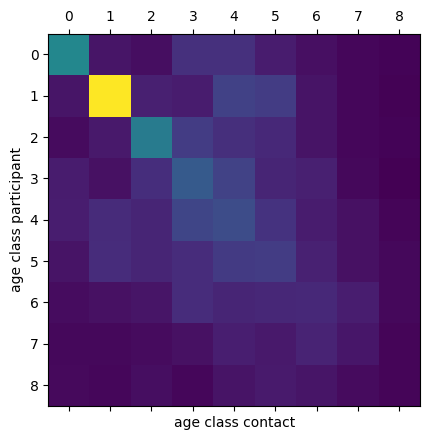

In [7]:
#read the contact matrix -> the matrix defined via R as described above
M_df = pd.read_csv('./Data_first_lab/matrix_Italy.csv').drop('Unnamed: 0', axis = 1)

plt.matshow(M_df) # this is a function that visualize an heatmap, a matrix is basically an heatmap. Here we should change the colors of the palette.
# the first age brachet is 0-10, the second is 10-20, and so on till the age group 80-90. We can see that in the diagonal we have a stronger connection because of teh stroger interactions between people of teh same age
plt.xlabel('age class contact')
plt.ylabel('age class participant')

In [8]:
def init_comp0(pop, key_seed, seeds):    # we define the compartments, they are empty at the initial state
    S0 = {}
    E0 = {} # the exposed compartment is a transition compartment between susceptible and infected, after a certain time, the exposed will become infected
    I0 = {}
    R0 = {}
    
    for i,key in enumerate(pop):    # we set a default value for the compartments. It is a function taht set the intial compartments
            
        S0.setdefault(key,{})
        E0.setdefault(key,{})
        I0.setdefault(key,{})
        R0.setdefault(key,{})
        
        if key == key_seed:
            Ii = seeds
        else:
            Ii = 0

   
        S0[key][0]= pop[key] - Ii
        E0[key][0]= 0
        I0[key][0]= Ii
        R0[key][0]=0
    
    return S0, E0, I0, R0

In [9]:
def run_epi(C0, pop, M,  beta_val:float, mu_val:float, eps_val:float, stop:int): # this function is needed to run the simulation.
    ''' takes in input the following:
    
    C0:  initilaization for the compartments
         list of dict -> C[key][0] = C0_val
    
    pop: population vecotr -> our population we simulate, with the specified age groups
         dict {key: pop_key}
         
    M:   contact matrix
         dict {key:{key1:c_val, key2:c_val}}
    
    Parameters definition: 
    beta_val: infection probability 
    mu_val:   recovery rate (1/d , d:generation time)
    eps_val:  probability to become infectious
    
    stop:   number of timesteps to simulate
    '''
    #. set initial compartments using C0
    #  compartment = [var1,var2][time]
    S,E,I,R = C0
    
    
    # . controlli -> check that the population and the contact matrix have the same dimentions and same keys
    keys = pop.keys()
    keys1 = M.keys()
    
    if keys!= keys1:
        print('Population vector and Contact matrix must have same keys!')

    # . running the epidemic -> for each age froup we run over them and for each age group compute the elements of teh compartments and we compute teh lambda_value that is the rate of infection
    for t in range(1,stop):
        print('t_{} '.format(t), end = '\r')        
        
        for m_key in keys:
            
            C_key = M[m_key]
            cc = []
            for kc in C_key:
                cc.append(C_key[kc]*(I[kc][t-1]/pop[kc]))
                #print(t, ':', I[kc][t-1])

            lambda_val = beta_val*sum(cc) # sum(cc) is the sum of one row over the matrix of infectious individual, we get the infectious term
            
            # for each age group we extract the new value of teh compartments, so infected, recovered and exposed.
            new_E = np.random.binomial(S[m_key][t-1] ,1.-np.exp(-lambda_val)) # formula from literature, here we set -lambda_val cause we cannot approximate lamba_val always positive 
            new_I = np.random.binomial(E[m_key][t-1] , eps_val)
            new_R = np.random.binomial(I[m_key][t-1] , mu_val)
                
            #  we update all teh compartments for all teh age groups  
            S[m_key][t] =  S[m_key][t-1] -  new_E
            E[m_key][t] =  E[m_key][t-1] +  new_E -  new_I
            
            I[m_key][t] =  I[m_key][t-1] +  new_I -  new_R
            R[m_key][t] =  R[m_key][t-1] +  new_R

        # compute the sum of all infected individuals in all the age groups
        totI = sum([I[key][t] for key in keys])
        
        # we stop at a time treshold
        if (t >300) and (totI < 1):
            break
                 
    return S,E, I,R, t

In [10]:
# re-arranging matrix as dictionary
M = {}
for i, m in enumerate(np.array(M_df)):
    M[i] = {i:mj for i,mj in enumerate(m)}

The R package [socialmixr](https://cran.r-project.org/web/packages/socialmixr/vignettes/socialmixr.html) 
also provides access to the demographics of each country.

In [11]:
# - population distribution by age in Italy -> this is the definition of teh number of individual in each age group
pop = {0: 5471539, # in the age group from 0 to 10 years we have 5471539 individuals
    1: 5732722,
    2: 6955502, 
    3: 9350120,
    4: 8838414, 
    5: 7705158, 
    6: 6584286,
    7: 5238248,
    8: 2932492,
    }

In [12]:
# initializing compartments at t=0
C0  = init_comp0(pop, np.random.randint(9), 10) # we initialize the compartments, we put 10 infected individuals in a random age group

# initializing epi parameters -> R0 is the value that tell us if the epidemic will grow (if >1) or not (if <1).
# In teh classic SIR model, we can easily compute beta by knowing R0 and mu
# Here, to get the beta value, we need to compute the eigenvalues of the contact matrix, we cannpt go with only the R0 and the mu value, we also need rho(mu) which is the spectral radius that is the higher eigenvalue.
def get_beta(M, R0, mu_val):
    
    eigvals, eigvecs = la.eig(M) # .la() compute the eigenvalues and eigenvector oa a matrix
    leading=eigvals.real[0] # we retrive the first element of teh eigenvalues, which we know is the higher
    
    beta_val=mu_val*R0/(leading) # we compute the beta value
    return beta_val

r0 = 3
mu_val = 1/4
eps_val = 1/2.5 # latency period to become infected once we are exposed, it takes an average of 2.5 days

beta_val = get_beta(M_df.values, r0, mu_val)

stop = 200

In [13]:
S,E,I,R,t = run_epi(C0,pop,M,  beta_val, mu_val, eps_val, stop)

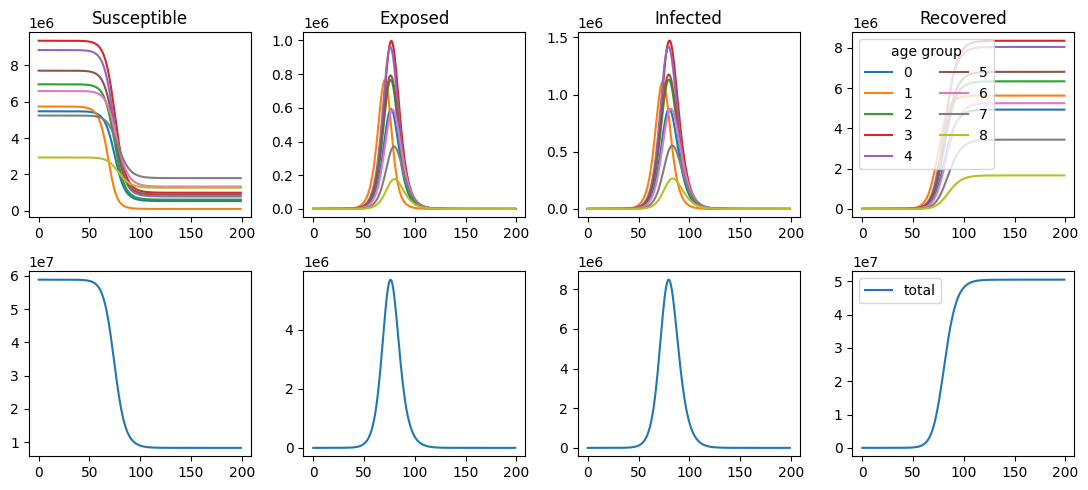

In [14]:
#Epi dynamic plots

fig, axs = plt.subplots(2,4 , figsize =(11, 5))#,  sharex='row', sharey='row')

r = 0
for key in S:
    axs[r, 0].plot(S[key].values())
    axs[r, 1].plot(E[key].values())
    axs[r, 2].plot(I[key].values())
    axs[r, 3].plot(R[key].values(), label = key)

for c,title in enumerate(['Susceptible', 'Exposed', 'Infected', 'Recovered']):
    axs[r,c].set_title(title)

axs[r, 3].legend(ncol = 2, title = 'age group')


S_tot = pd.DataFrame(S).sum(axis = 1)
E_tot = pd.DataFrame(E).sum(axis = 1)
I_tot = pd.DataFrame(I).sum(axis = 1)
R_tot = pd.DataFrame(R).sum(axis = 1)


r = 1
axs[r, 0].plot(S_tot)
axs[r, 1].plot(E_tot)
axs[r, 2].plot(I_tot)
axs[r, 3].plot(R_tot, label = 'total')
axs[r, 3].legend(ncol = 2)

plt.tight_layout()

We can see that we have 9 age groups. We can see that the number of Exposed and Susceptible have different drops and growth based on the age group. The more contact you make with the age group, the more infected you get. Indeed, in teh plots above, we can see that the bigger peack is observed in teh smaller age groups, because of the high contact rate.

The plots in blue are the sum of all the age groups.

NB. This contact matrix comes from a survey. So it can really change based on that.
